In [13]:
import os, sys
os.chdir('../')

In [14]:
import argparse
import torch
import sys
import os
import json
import random
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn.covariance
import scipy
import pdb

import data_loader.data_loaders as module_data
import loss as module_loss
import model.metric as module_metric
import model.model as module_arch
import torch.nn as nn
import torch.nn.functional as F
import model.model as module_arch
from trainer import DefaultTrainer, TruncatedTrainer, GroundTruthTrainer, DynamicTrainer
from collections import OrderedDict
from utils.util import *
from utils.args import *

from sklearn import metrics
from sklearn import cluster
from tqdm import tqdm
from torch.autograd import Variable
from utils.parse_config import ConfigParser


In [15]:
!pwd

/home/sangwook/jupyter/noisy_label


In [16]:
os.chdir('/home/sangwook/jupyter/noisy_label/ELR/robust_loss_coteaching' )

In [17]:
def return_statistics(isNoisy_list, predict):
    r_stats = []
    
    tp = (isNoisy_list[predict==0]==0).sum()
    tn = isNoisy_list[predict==1].sum()
    fp = isNoisy_list.sum() - tn
    fn = ((isNoisy_list.shape - isNoisy_list.sum()) - tp).item()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sel_samples = int(fp + tp)
    frac_clean = tp / (fp + tp)

    r_stats.extend([sel_samples, round(precision, 5), round(recall, 5), round(specificity, 5), round(accuracy, 5), round(frac_clean, 5)])
    
    return r_stats

# return_statistics(isNoisy_list, sing_lbl)

def stat_summary(name, stat_list):
    print('Dataset: {}, Net: {}, Noise{}_{}, Loss: {}'
      .format(config['data_loader']['type'], config['arch']['type'], config['trainer']['asym'], config['trainer']['percent'], config['train_loss']['type']))
    
    print("="*50, name , "="*50)

    print('Selected samples by {}: {} \nPrecision: {} \nRecall: {} \nSpecificity: {}\nAccuracy: {} \nFraction of clean samples/selected samples: {}'
                  .format(name, stat_list[0], stat_list[1], stat_list[2], stat_list[3], stat_list[4], stat_list[5]))


# Config Setting

In [18]:
# config_file = './hyperparams/multistep/config_cifar10_cce_rn34.json'
config_file = './saved/models/cifar10/resnet34/MultiStepLR/CCELoss/sym/80/config_123.json' #cifar 100
with open(config_file, 'r') as f:
    config = json.load(f)
    
device = torch.device('cuda:1')

In [19]:
config

{'name': 'cifar10_resnet34_multistep',
 'n_gpu': 1,
 'seed': 123,
 'arch': {'type': 'resnet34', 'args': {'num_classes': 10}},
 'num_classes': 10,
 'data_loader': {'type': 'CIFAR10DataLoader',
  'args': {'data_dir': './dir_to_data',
   'batch_size': 128,
   'shuffle': True,
   'num_batches': 0,
   'validation_split': 0,
   'num_workers': 8,
   'pin_memory': True}},
 'optimizer': {'type': 'SGD',
  'args': {'lr': 0.02, 'momentum': 0.9, 'weight_decay': 0.001}},
 'train_loss': {'type': 'CCELoss'},
 'val_loss': 'CrossEntropyLoss',
 'metrics': ['my_metric', 'my_metric2'],
 'lr_scheduler': {'type': 'MultiStepLR',
  'args': {'milestones': [40, 80], 'gamma': 0.01}},
 'trainer': {'epochs': 120,
  'warmup': 0,
  'save_dir': 'saved/',
  'save_period': 1,
  'verbosity': 2,
  'label_dir': 'saved/',
  'monitor': 'max test_my_metric',
  'early_stop': 2000,
  'tensorboard': False,
  'mlflow': True,
  '_percent': 'Percentage of noise',
  'percent': 0.8,
  '_begin': 'When to begin updating labels',
  'beg

In [20]:
resume_path = './saved/models/cifar10/resnet34/MultiStepLR/CCELoss/sym/80/model_best123.pth'
base_model = getattr(module_arch, config["arch"]['type'])()
checkpoint = torch.load(resume_path)
state_dict = checkpoint['state_dict']
base_model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
# set seed
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])
torch.backends.cudnn.deterministic = True
np.random.seed(config['seed'])

data_loader = getattr(module_data, config['data_loader']['type'])(
    config['data_loader']['args']['data_dir'],
    batch_size= 100,
    shuffle=config['data_loader']['args']['shuffle'],
    validation_split=0.0,
    num_batches=config['data_loader']['args']['num_batches'],
    training=True,
    num_workers=config['data_loader']['args']['num_workers'],
    pin_memory=config['data_loader']['args']['pin_memory'],
    config=config
)

if hasattr(data_loader.dataset, 'num_raw_example'):
    num_examp = data_loader.dataset.num_raw_example
else:
    num_examp = len(data_loader.dataset)

critenrion = nn.CrossEntropyLoss()

Files already downloaded and verified
##############
[8 9 1 9 4 8 3 6 3 6]
[3 2 1 1 3 2 2 7 6 5]
Train: 50000 Val: 0


# Base ResNet

In [22]:
class Represent(nn.Module):
    def __init__(self, base_model):
        super(Represent, self).__init__()
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.linear = base_model.linear
        
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        y = out.view(out.size(0), -1)
        
        return y
    
    #Feature Extractting
    def feature_list(self, x):
        output_list = []
        out = F.relu(self.bn1(self.conv1(x)))
        for name, module in self.layer1._modules.items():
            out = module(out)
        for name, module in self.layer2._modules.items():
            out = module(out)
        for name, module in self.layer3._modules.items():
            out = module(out)
        for name, module in self.layer4._modules.items():
            out = module(out)
            output_list.append(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, output_list

In [23]:
model = Represent(base_model)

In [24]:
isNoisy_list = np.empty((0,))
isFalse_list = np.empty((0,))
label_list = np.empty((0,))
gt_list = np.empty((0,))
conf_list = np.empty((0,))
loss_list = np.empty((0,))

# SAME Threshold

In [25]:
model.eval()
model.to(device)
loss = 0
with tqdm(data_loader) as progress:
    for batch_idx, (data, label, index, label_gt) in enumerate(progress):
        data = data.to(device)
        label, label_gt = label.long().to(device), label_gt.long().to(device)
        output = model(data)
        _, prediction = base_model(data)
        loss = torch.nn.CrossEntropyLoss(reduction='none')(prediction, label)
        confidence, _ = torch.max(torch.nn.functional.softmax(prediction, dim=1), dim=1)
        isNoisy  = label != label_gt
        
        gt_list = np.concatenate((gt_list, label_gt.cpu()))
        label_list = np.concatenate((label_list, label.cpu()))
        isNoisy_list = np.concatenate((isNoisy_list, isNoisy.cpu()))
        conf_list = np.concatenate((conf_list, confidence.detach().cpu()))
        loss_list = np.concatenate((loss_list, loss.detach().cpu()))
        if batch_idx == 0:
            out_list = output.detach().cpu()
        else:
            out_list = np.concatenate((out_list, output.detach().cpu()), axis=0)

100%|██████████| 500/500 [00:29<00:00, 16.87it/s]


In [26]:
def get_singular_value_vector(label_list, out_list):
    
    singular_dict = {}
    v_ortho_dict = {}
    
    for index in np.unique(label_list):
        u, s, v = np.linalg.svd(out_list[label_list==index])
        singular_dict[index] = s[0] / s[1]
        v_ortho_dict[index] = torch.from_numpy(v[:2])

    return singular_dict, v_ortho_dict

In [27]:
# Max eigen vector 보다 작으면 1(Noisy Label)
def singular_label(v_ortho_dict, model_represents, label):
    
    model_represents = torch.from_numpy(model_represents).to(device)
    sing_lbl = torch.zeros(model_represents.shape[0]) 
    sin_score_lbl = torch.zeros(model_represents.shape[0])
    
    for i, data in enumerate(model_represents):
        sin_score_lbl[i] = torch.dot(v_ortho_dict[label[i]][0], data).abs() - torch.dot(v_ortho_dict[label[i]][1], data).abs()
        if torch.dot(v_ortho_dict[label[i]][0], data).abs() < torch.dot(v_ortho_dict[label[i]][1], data).abs():
            sing_lbl[i] = 1
        
    return sing_lbl, sin_score_lbl

# Kmeans wrt alginment score

In [13]:
def kmean_singular_label(v_ortho_dict, model_represents, label):
    
    model_represents = torch.from_numpy(model_represents).to(device)
    sing_lbl = torch.zeros(model_represents.shape[0])
    sin_score_lbl = torch.zeros(model_represents.shape[0])
    
    for i, data in enumerate(model_represents):
        sin_score_lbl[i] = torch.dot(v_ortho_dict[label[i]][0], data).abs() - torch.dot(v_ortho_dict[label[i]][1], data).abs()
        
    kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(sin_score_lbl.reshape(-1, 1))
    
    return kmeans, sin_score_lbl

In [14]:
def kmean_singular_label_t1(v_ortho_dict, model_represents, label):
    
    model_represents = torch.from_numpy(model_represents).to(device)
    sing_lbl = torch.zeros(model_represents.shape[0])
    sin_score_lbl = torch.zeros(model_represents.shape[0])
    
    for i, data in enumerate(model_represents):
        sin_score_lbl[i] = torch.dot(v_ortho_dict[label[i]][0], data).abs()
        
    kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(sin_score_lbl.reshape(-1, 1))
    
    return kmeans, sin_score_lbl

In [15]:
singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)

for key in v_ortho_dict.keys():
    v_ortho_dict[key] = v_ortho_dict[key].to(device)

ksin_score_lbl, sin_score_lbl = kmean_singular_label_t1(v_ortho_dict, out_list, label_list)


In [16]:
print(len(ksin_score_lbl.labels_==1))
print('Max: ',torch.max(sin_score_lbl))
print('Min: ',torch.min(sin_score_lbl))

sin_score_np = sin_score_lbl.cpu().detach().numpy()

if torch.mean(sin_score_lbl[ksin_score_lbl.labels_==0]) < torch.mean(sin_score_lbl[ksin_score_lbl.labels_==1]):
    ksin_score_lbl.labels_ = 1 - ksin_score_lbl.labels_

50000
Max:  tensor(3.3518)
Min:  tensor(0.4418)


(array([3.200e+01, 1.420e+02, 1.630e+02, 3.700e+02, 7.750e+02, 1.212e+03,
        1.648e+03, 1.916e+03, 2.109e+03, 2.247e+03, 2.303e+03, 2.305e+03,
        2.355e+03, 2.191e+03, 2.125e+03, 1.964e+03, 1.816e+03, 1.573e+03,
        1.528e+03, 1.369e+03, 1.234e+03, 1.127e+03, 1.065e+03, 9.500e+02,
        8.140e+02, 7.440e+02, 7.030e+02, 6.180e+02, 6.300e+02, 5.460e+02,
        5.780e+02, 5.250e+02, 5.350e+02, 5.180e+02, 5.040e+02, 4.720e+02,
        4.750e+02, 4.950e+02, 4.820e+02, 5.310e+02, 5.060e+02, 5.410e+02,
        5.620e+02, 4.960e+02, 4.680e+02, 4.290e+02, 4.090e+02, 4.340e+02,
        3.960e+02, 3.380e+02, 2.860e+02, 2.730e+02, 1.860e+02, 1.500e+02,
        1.500e+02, 1.150e+02, 9.000e+01, 7.700e+01, 7.200e+01, 4.600e+01,
        4.100e+01, 2.800e+01, 3.200e+01, 2.400e+01, 2.500e+01, 1.200e+01,
        1.600e+01, 1.100e+01, 7.000e+00, 1.100e+01, 1.000e+01, 9.000e+00,
        8.000e+00, 6.000e+00, 5.000e+00, 7.000e+00, 0.000e+00, 6.000e+00,
        9.000e+00, 1.000e+00, 1.000e+0

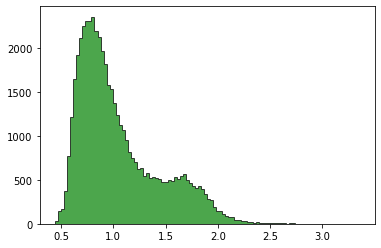

In [17]:
plt.hist((sin_score_np), color='Green', alpha=0.7, histtype='stepfilled', bins=100, ec='k')

In [18]:
(ksin_score_lbl.labels_==0).shape
np.sum(ksin_score_lbl.labels_==0)
print(np.sum(ksin_score_lbl.labels_==0) + np.sum(ksin_score_lbl.labels_==1))
np.sum(ksin_score_lbl.labels_==1)

50000


36855

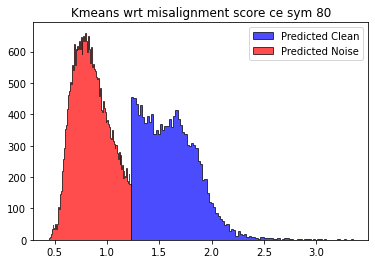

In [19]:
kwargs = dict(histtype='stepfilled', alpha=1, bins=100, ec="k")

#Clean Data
plt.hist((sin_score_np[ksin_score_lbl.labels_==0]), label='Predicted Clean', color='Blue', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Clean Data
# plt.hist((sin_score_np[isNoisy_list==0]), label='Conditioned Clean', color='Orange', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Clean Data
#Noisy Data
plt.hist((sin_score_np[ksin_score_lbl.labels_==1]), label='Predicted Noise', color='Red', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Noisy Data
# plt.hist((sin_score_np[isNoisy_list==1]), label='Conditioned Noise', color='purple', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Noisy Data
plt.legend(loc='best')
plt.title('Kmeans wrt misalignment score ce sym 80')
plt.show()

In [20]:
len(sin_score_np[isNoisy_list==0])
print('Predicted Noisy Mean:',torch.mean(sin_score_lbl[ksin_score_lbl.labels_==1]))
print('Predicted Noisy Var:',torch.var(sin_score_lbl[ksin_score_lbl.labels_==1]))
print('Predicted Noisy Max:',torch.max(sin_score_lbl[ksin_score_lbl.labels_==1]))
print('Predicted Noisy Min:',torch.min(sin_score_lbl[ksin_score_lbl.labels_==1]))

print('Predicted Clean Mean:',torch.mean(sin_score_lbl[isNoisy_list==0]))
print('Predicted Clean Var:',torch.var(sin_score_lbl[isNoisy_list==0]))
print('Predicted Clean Max:',torch.max(sin_score_lbl[isNoisy_list==0]))
print('Predicted Clean Min:',torch.min(sin_score_lbl[isNoisy_list==0]))

Predicted Noisy Mean: tensor(0.8486)
Predicted Noisy Var: tensor(0.0293)
Predicted Noisy Max: tensor(1.2311)
Predicted Noisy Min: tensor(0.4418)
Predicted Clean Mean: tensor(1.5211)
Predicted Clean Var: tensor(0.1197)
Predicted Clean Max: tensor(3.3518)
Predicted Clean Min: tensor(0.4924)


In [21]:
kmean_ma_stat = return_statistics(isNoisy_list, ksin_score_lbl.labels_)
stat_summary('k-means wrt misalignmet score', kmean_ma_stat)

Dataset: CIFAR10DataLoader, Net: resnet34, NoiseFalse_0.8, Loss: CCELoss
================================================== k-means wrt misalignmet score ==================================================
Selected samples by k-means wrt misalignmet score: 13145 
Precision: 0.84222 
Recall: 0.79282 
Specificity: 0.94245
Accuracy: 0.90066 
Fraction of clean samples/selected samples: 0.84222


# GMM wrt alignment score

# Original SAME(Threshold=0)

In [22]:
#For singular vector analysis
singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)

for key in v_ortho_dict.keys():
    v_ortho_dict[key] = v_ortho_dict[key].to(device)

tmp_label_list = label_list.copy()
model_rep = out_list.copy()
model_represents = torch.from_numpy(model_rep).to(device)
sing_lbl = torch.zeros(model_represents.shape[0])
sin_score_lbl = torch.zeros(model_represents.shape[0])

#sin_score 1 indicates the predicted noisy data from given detector
for i, data in enumerate(model_represents):
    sin_score_lbl[i] = torch.dot(v_ortho_dict[tmp_label_list[i]][0], data).abs() - torch.dot(v_ortho_dict[tmp_label_list[i]][1], data).abs()
    if sin_score_lbl[i] < 0:
        sing_lbl[i] = 1



In [23]:
v_ortho_dict[0.0].shape

torch.Size([2, 512])

In [24]:
# #Using Function
# singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)

# for key in v_ortho_dict.keys():
#     v_ortho_dict[key] = v_ortho_dict[key].to(device)

# sing_lbl_1, sin_score_lbl_1 = singular_label(v_ortho_dict, out_list, label_list)

# # This is for CLK Algorithm which clusters based on the loss value
# # kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(loss_list.reshape(-1,1))

In [25]:
sin_score_lbl[:20]

tensor([ 0.0414,  0.2117, -0.2247,  0.0798,  0.2572, -0.2654, -0.0974,  0.0822,
         0.1484,  0.3377,  0.1472,  0.3865, -0.0050,  0.6240,  0.0449,  0.3154,
         0.8214,  0.5532,  0.6837,  0.2097])

# Visualize the differences of eigenvalue of top1 and top2


In [26]:
print('Max: ',torch.max(sin_score_lbl))
print('Min: ',torch.min(sin_score_lbl))

sin_score_np = sin_score_lbl.cpu().detach().numpy()

Max:  tensor(1.6478)
Min:  tensor(-0.5825)


### Visualization without label information

(array([6.000e+00, 5.000e+00, 1.300e+01, 1.900e+01, 4.000e+01, 6.400e+01,
        5.400e+01, 1.080e+02, 1.210e+02, 1.510e+02, 1.780e+02, 2.270e+02,
        2.420e+02, 2.990e+02, 3.460e+02, 4.330e+02, 4.390e+02, 5.320e+02,
        5.920e+02, 5.690e+02, 6.880e+02, 8.150e+02, 1.002e+03, 1.029e+03,
        1.116e+03, 1.102e+03, 9.970e+02, 1.052e+03, 1.075e+03, 1.169e+03,
        1.244e+03, 1.340e+03, 1.296e+03, 1.287e+03, 1.251e+03, 1.224e+03,
        1.182e+03, 1.058e+03, 1.045e+03, 9.550e+02, 9.200e+02, 9.060e+02,
        8.840e+02, 7.960e+02, 7.310e+02, 7.260e+02, 6.630e+02, 6.940e+02,
        6.620e+02, 6.030e+02, 5.880e+02, 6.140e+02, 5.700e+02, 6.290e+02,
        6.450e+02, 6.370e+02, 6.660e+02, 6.410e+02, 6.270e+02, 5.970e+02,
        5.480e+02, 5.570e+02, 5.510e+02, 5.290e+02, 5.480e+02, 5.120e+02,
        4.910e+02, 4.570e+02, 4.730e+02, 4.500e+02, 3.710e+02, 4.090e+02,
        3.640e+02, 3.640e+02, 3.270e+02, 3.090e+02, 3.220e+02, 2.770e+02,
        2.890e+02, 2.430e+02, 2.080e+0

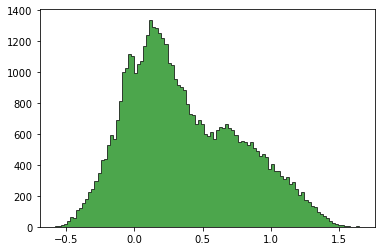

In [27]:
#Whole data distribution wrt alignment with singular vectors
plt.hist((sin_score_np), color='Green', alpha=0.7, histtype='stepfilled', bins=100, ec='k')

### Visualization with label information

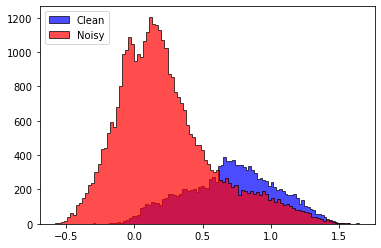

In [28]:
kwargs = dict(histtype='stepfilled', alpha=1, bins=100, ec="k")

#Clean Data
plt.hist((sin_score_np[isNoisy_list==0]), label='Clean', color='Blue', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Clean Data
#Noisy Data
plt.hist((sin_score_np[isNoisy_list==1]), label='Noisy', color='Red', alpha=0.7, histtype='stepfilled', bins=100, ec='k') #Noisy Data
plt.legend(loc='upper left')
plt.savefig('figure/ce_sym20_sin_difference.png')
plt.show()

In [29]:
len(sin_score_np[isNoisy_list==0])
print('Noisy Mean:',torch.mean(sin_score_lbl[isNoisy_list==1]))
print('Noisy Var:',torch.var(sin_score_lbl[isNoisy_list==1]))
print('Noisy Max:',torch.max(sin_score_lbl[isNoisy_list==1]))
print('Noisy Min:',torch.min(sin_score_lbl[isNoisy_list==1]))

print('Clean Mean:',torch.mean(sin_score_lbl[isNoisy_list==0]))
print('Clean Var:',torch.var(sin_score_lbl[isNoisy_list==0]))
print('Clean Max:',torch.max(sin_score_lbl[isNoisy_list==0]))
print('Clean Min:',torch.min(sin_score_lbl[isNoisy_list==0]))

Noisy Mean: tensor(0.2257)
Noisy Var: tensor(0.1273)
Noisy Max: tensor(1.6478)
Noisy Min: tensor(-0.5825)
Clean Mean: tensor(0.7044)
Clean Var: tensor(0.1110)
Clean Max: tensor(1.6104)
Clean Min: tensor(-0.4286)
